In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np
import os

2024-03-21 14:04:44.303749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 14:04:44.334955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 14:04:44.334983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 14:04:44.335775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 14:04:44.340784: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0


In [2]:
test_data = './test-data/'
test_meta_path = '../meta-test/'
val_data = './val-data/'
val_meta_path = '../meta-val/'
test_folders = np.sort(np.sort(os.listdir(test_data)))
val_folders = np.sort(np.sort(os.listdir(val_data)))

In [3]:
normal_meta_test = pd.read_csv(test_meta_path + 'normal-metadata-test.csv')
osmf_meta_test = pd.read_csv(test_meta_path + 'osmf-metadata-test.csv')
normal_osmf_meta_test = pd.concat([normal_meta_test, osmf_meta_test], ignore_index=True)
normal_osmf_meta_test['type'] = normal_osmf_meta_test['type'].apply(lambda x: 1 if x == 'OSMF' else 0)

normal_meta_val = pd.read_csv(val_meta_path + 'normal-metadata-val.csv')
osmf_meta_val = pd.read_csv(val_meta_path + 'osmf-metadata-val.csv')
normal_osmf_meta_val = pd.concat([normal_meta_val, osmf_meta_val], ignore_index=True)
normal_osmf_meta_val['type'] = normal_osmf_meta_val['type'].apply(lambda x: 1 if x == 'OSMF' else 0)

Normal = 0

OSMF = 1

In [4]:
def get_model(fold):
    model_path = f'./results/fold-{fold}/model_fine.h5'
    print(f'Loading model from {model_path}...')
    model = load_model(model_path)
    return model

In [5]:
def image_process(path):
    img = image.load_img(path, target_size=(520, 520))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, x.shape

In [6]:
def result_process(pred):
    print(pred)
    classes = [0, 1]
    results = []
    results_prob = []
    for i in range(len(pred)):
        '''
        print(f'Prediction: {pred[i]}')
        print(f'Prediction Shape: {pred[i].shape}')
        print(f'Predicted class: {np.argmax(pred[i])}')
        print(f'Predicted class name: {classes[np.argmax(pred[i])]}')
        print(f'Predicted class probability: {pred[i][np.argmax(pred[i])]}')
        '''
        results.append(classes[np.argmax(pred[i])])
        results_prob.append(pred[i][np.argmax(pred[i])])

    return results[0], results_prob[0]

In [7]:
def dataloader_test(folders, meta, isVal=False):
    _paths = []
    _labels = []
    data_path = val_data if isVal else test_data

    for folder in folders:
        for file in os.listdir(data_path+folder):
            _paths.append(data_path+folder+'/'+file)
            _labels.append(meta[meta['folder']==folder]['type'].values[0])
    print(f'Loading for {data_path}...')
    print(f'Loaded {len(_paths)} images')
    print(f'Loaded {len(_labels)} labels', end='\n\n')
    _paths = np.array(_paths)
    _labels = np.array(_labels)
    seed = 42
    perm = np.random.permutation(len(_paths))
    _paths = _paths[perm]
    _labels = _labels[perm]

    return _paths, _labels

In [8]:
test_folders

array(['001-014', '001-018', '001-020', '002-024', '002-025', '002-028',
       '002-029', '004-001'], dtype='<U7')

In [9]:
test_paths, test_labels = dataloader_test(test_folders, normal_osmf_meta_test)
val_paths, val_labels = dataloader_test(val_folders, normal_osmf_meta_val, isVal=True)

Loading for ./test-data/...
Loaded 508 images
Loaded 508 labels

Loading for ./val-data/...
Loaded 197 images
Loaded 197 labels



In [10]:
def infer(fold, paths, isVal=False):
    result_file_name = 'results_val.csv' if isVal else 'results_test.csv'
    model = get_model(fold)
    all_results = pd.DataFrame(columns=['filename', 'label', 'prediction'])
    for i in range(len(paths)):
        x, shape = image_process(paths[i])
        pred = model.predict(x)
        result, result_prob = result_process(pred)
        row = {'filename': paths[i].split('/')[-2] + '/' + paths[i].split('/')[-1], 'label': test_labels[i], 'prediction': result, 'prediction_prob': result_prob}
        all_results  = pd.concat([all_results, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    all_results.to_csv(f'./results/fold-{fold}/{result_file_name}', index=False)
    return all_results

In [11]:
def plot_history(history_pre, history_fine, fold, isVal=False):
    save_file_name = 'history-plot-val.png' if isVal else 'history-plot-test.png'
    # Plot for Pre-Training
    plt.figure(figsize=(15, 10))

    # Subplot for Pre-Training Accuracy
    # plt.title('Pre-Training Accuracy and Loss for Fold-1', loc='center', fontsize=12, color='blue', weight='bold')cd b    
    plt.subplot(2, 2, 1)
    plt.plot(history_pre['accuracy'])
    plt.plot(history_pre['val_accuracy'])
    plt.title('Pre-Training Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # Subplot for Pre-Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(history_pre['loss'])
    plt.plot(history_pre['val_loss'])
    plt.title('Pre-Training Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Plot for Fine-Tuning
    # Subplot for Fine-Tuning Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history_fine['accuracy'])
    plt.plot(history_fine['val_accuracy'])
    plt.title('Fine-Tuning Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Subplot for Fine-Tuning Loss
    plt.subplot(2, 2, 4)
    # plt.title('Fine-Tuning Accuracy and Loss for Fold-1', loc='center', fontsize=12, color='green', weight='bold')
    plt.plot(history_fine['loss'])
    plt.plot(history_fine['val_loss'])
    plt.title('Fine-Tuning Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # Add titles for each row
    subtitle = 'Validation' if isVal else 'Test'
    plt.suptitle(f'Comparison of Pre-Training and Fine-Tuning for Fold-{fold} in {subtitle} Data')
    # Adjust layout to prevent overlap of titles and labels
    plt.tight_layout()
    # Show the combined plot
    plt.savefig(f'./results/fold-{fold}/{save_file_name}')
    plt.show()


In [12]:
'''
def plot_cm(cm, target_names, fold):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix for Fold-{fold}')
    ax.xaxis.set_ticklabels(target_names)
    ax.yaxis.set_ticklabels(target_names)
    plt.savefig(f'/media/chs.gpu/chs-rintu/osmf-osmf/xception-out/fold-{fold}/cm.png')
    plt.show()
'''

"\ndef plot_cm(cm, target_names, fold):\n    ax = plt.subplot()\n    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')\n    ax.set_xlabel('Predicted labels')\n    ax.set_ylabel('True labels')\n    ax.set_title(f'Confusion Matrix for Fold-{fold}')\n    ax.xaxis.set_ticklabels(target_names)\n    ax.yaxis.set_ticklabels(target_names)\n    plt.savefig(f'/media/chs.gpu/chs-rintu/osmf-osmf/xception-out/fold-{fold}/cm.png')\n    plt.show()\n"

In [13]:
def plot_cm(cm, target_names, fold, fontsize=20, figsize=(6, 4), isVal=False):
    save_file_name = 'cm-val.png' if isVal else 'cm-test.png'
    subtitle = 'Validation' if isVal else 'Test'
    plt.figure(figsize=figsize)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g', annot_kws={"fontsize": fontsize})
    ax.set_xlabel('Predicted labels', fontsize=fontsize, color='black')
    ax.set_ylabel('True labels', fontsize=fontsize, color='black')
    ax.set_title(f'({subtitle}) Fold-{fold}', fontsize=fontsize, color='black')
    ax.xaxis.set_ticklabels(target_names, fontsize=fontsize, color='black')
    ax.yaxis.set_ticklabels(target_names, fontsize=fontsize, color='black')
    plt.tight_layout()
    plt.savefig(f'./results/fold-{fold}/{save_file_name}')

In [14]:
def save_results(history_pre_path, history_fine_path, results_path, target_names, folds, isVal=False):
    report_file_name = 'report-val.txt' if isVal else 'report-test.txt'
    history_pre = pkl.load(open(history_pre_path, 'rb'))
    history_fine = pkl.load(open(history_fine_path, 'rb'))
    plot_history(history_pre, history_fine, folds, isVal)
    print('History plot saved!')
    results = pd.read_csv(results_path)
    true_labels = results['label'].values
    pred_lables = results['prediction'].values
    cm = confusion_matrix(true_labels, pred_lables)
    print('Confusion Matrix:\n', cm)
    plot_cm(cm, target_names, folds, isVal=isVal)
    print('Confusion Matrix plot saved!')
    report = classification_report(true_labels, pred_lables, target_names=target_names)
    print('Classification Report:\n', report)
    with open(f'./results/fold-{folds}/{report_file_name}', 'w') as f:
        f.write(report)
    print('Classification Report saved!')
    print('Done!')

In [15]:
folds = [1,2,3]
for fold in tqdm(folds):
    print(f'Infering fold {fold}...')
    test_results = infer(fold, test_paths)
    print(f'Infering fold {fold}...Done!', end='\n\n')

  0%|          | 0/3 [00:00<?, ?it/s]

Infering fold 1...
Loading model from ./results/fold-1/model_fine.h5...


2024-03-21 14:04:47.851549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21960 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-03-21 14:04:52.507997: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-21 14:04:53.538172: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 14:04:53.540355: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-03-21 14:04:53.540367: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-03-21 14:04:53.540406: W external/local_xla/xla/stream_ex

1/1 [==============================] - 4s 4s/step


2024-03-21 14:04:53.777557: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-21 14:04:53.779544: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


[[1.0000000e+00 2.0471742e-09]]
1/1 [==============================] - 0s 24ms/step
[[0.9956191  0.00438084]]
1/1 [==============================] - 0s 94ms/step
[[9.9999976e-01 2.0428230e-07]]
1/1 [==============================] - 0s 27ms/step
[[1.0000000e+00 2.8022052e-08]]
1/1 [==============================] - 0s 109ms/step
[[4.729273e-16 1.000000e+00]]
1/1 [==============================] - 0s 19ms/step
[[0. 1.]]
1/1 [==============================] - 0s 129ms/step
[[0. 1.]]
1/1 [==============================] - 0s 24ms/step
[[1.0972581e-17 1.0000000e+00]]
1/1 [==============================] - 0s 113ms/step
[[9.9902487e-01 9.7514514e-04]]
1/1 [==============================] - 0s 21ms/step
[[0.00822015 0.99177986]]
1/1 [==============================] - 0s 102ms/step
[[6.248349e-15 1.000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[8.3181253e-26 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[3.6743823e-28 1.0000000e+00]]
1/1 [===========

 33%|███▎      | 1/3 [00:44<01:29, 44.76s/it]

[[2.2315413e-11 1.0000000e+00]]
Infering fold 1...Done!

Infering fold 2...
Loading model from ./results/fold-2/model_fine.h5...
1/1 [==============================] - 0s 496ms/step
[[1.0000000e+00 1.1601218e-08]]
1/1 [==============================] - 0s 33ms/step
[[0.0273185 0.9726815]]
1/1 [==============================] - 0s 20ms/step
[[9.9999547e-01 4.5759002e-06]]
1/1 [==============================] - 0s 19ms/step
[[9.9996960e-01 3.0361014e-05]]
1/1 [==============================] - 0s 19ms/step
[[1.8679158e-10 1.0000000e+00]]
1/1 [==============================] - 0s 19ms/step
[[1.514567e-32 1.000000e+00]]
1/1 [==============================] - 0s 20ms/step
[[3.695407e-06 9.999963e-01]]
1/1 [==============================] - 0s 20ms/step
[[2.0734006e-09 1.0000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[5.2426611e-05 9.9994755e-01]]
1/1 [==============================] - 0s 20ms/step
[[1.0000000e+00 1.8561648e-09]]
1/1 [==============================] - 0s 

 67%|██████▋   | 2/3 [01:23<00:41, 41.49s/it]

Infering fold 2...Done!

Infering fold 3...
Loading model from ./results/fold-3/model_fine.h5...
1/1 [==============================] - 0s 467ms/step
[[1.0000000e+00 5.2941722e-08]]
1/1 [==============================] - 0s 20ms/step
[[9.999999e-01 1.738941e-07]]
1/1 [==============================] - 0s 22ms/step
[[0.99757713 0.00242287]]
1/1 [==============================] - 0s 20ms/step
[[9.9999905e-01 8.9938339e-07]]
1/1 [==============================] - 0s 23ms/step
[[9.921072e-18 1.000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[0. 1.]]
1/1 [==============================] - 0s 22ms/step
[[1.7378072e-22 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[1.6037211e-18 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[9.9942744e-01 5.7264592e-04]]
1/1 [==============================] - 0s 19ms/step
[[9.999460e-01 5.395744e-05]]
1/1 [==============================] - 0s 23ms/step
[[9.563496e-12 1.000000e+00]]
1/1 [=========

100%|██████████| 3/3 [02:03<00:00, 41.02s/it]

[[0.1650372 0.8349628]]
Infering fold 3...Done!



In [16]:
val_paths

array(['./val-data/002-018/0322.png', './val-data/001-015/0004.png',
       './val-data/001-015/0014.png', './val-data/001-015/0036.png',
       './val-data/002-018/0334.png', './val-data/002-018/0317.png',
       './val-data/001-015/0032.png', './val-data/001-019/0006.png',
       './val-data/002-018/0357.png', './val-data/002-018/0360.png',
       './val-data/001-019/0024.png', './val-data/002-016/0131.png',
       './val-data/002-018/0320.png', './val-data/002-016/0089.png',
       './val-data/002-018/0351.png', './val-data/001-019/0030.png',
       './val-data/001-013/0013.png', './val-data/002-018/0349.png',
       './val-data/002-018/0366.png', './val-data/001-013/0017.png',
       './val-data/001-019/0020.png', './val-data/001-015/0013.png',
       './val-data/002-016/0108.png', './val-data/001-015/0031.png',
       './val-data/001-013/0008.png', './val-data/001-015/0012.png',
       './val-data/001-013/0014.png', './val-data/002-018/0335.png',
       './val-data/002-016/0126.pn

In [17]:
folds = [1,2,3]
for fold in tqdm(folds):
    print(f'Infering fold {fold}...')
    val_results = infer(fold, val_paths, isVal=True)
    print(f'Infering fold {fold}...Done!', end='\n\n')

  0%|          | 0/3 [00:00<?, ?it/s]

Infering fold 1...
Loading model from ./results/fold-1/model_fine.h5...
1/1 [==============================] - 0s 497ms/step
[[1.3558228e-31 1.0000000e+00]]
1/1 [==============================] - 0s 30ms/step
[[4.368869e-27 1.000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[9.48412e-37 1.00000e+00]]
1/1 [==============================] - 0s 23ms/step
[[1.4814763e-06 9.9999857e-01]]
1/1 [==============================] - 0s 20ms/step
[[3.6425635e-20 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[4.717532e-13 1.000000e+00]]
1/1 [==============================] - 0s 39ms/step
[[3.015193e-31 1.000000e+00]]
1/1 [==============================] - 0s 23ms/step
[[2.017762e-21 1.000000e+00]]
1/1 [==============================] - 0s 20ms/step
[[9.9999988e-01 1.6144965e-07]]
1/1 [==============================] - 0s 23ms/step
[[4.5137206e-08 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[2.8803854e-06 9.9999714e-01]]
1/1 [==========

 33%|███▎      | 1/3 [00:16<00:32, 16.30s/it]

[[9.999918e-01 8.272503e-06]]
Infering fold 1...Done!

Infering fold 2...
Loading model from ./results/fold-2/model_fine.h5...
1/1 [==============================] - 1s 505ms/step
[[2.106894e-18 1.000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[4.5150373e-27 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[3.2997446e-20 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[2.2977116e-21 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[4.2272437e-05 9.9995768e-01]]
1/1 [==============================] - 0s 22ms/step
[[0.02281293 0.9771871 ]]
1/1 [==============================] - 0s 22ms/step
[[2.6865647e-09 1.0000000e+00]]
1/1 [==============================] - 0s 20ms/step
[[3.6646024e-18 1.0000000e+00]]
1/1 [==============================] - 0s 23ms/step
[[9.9910885e-01 8.9116633e-04]]
1/1 [==============================] - 0s 19ms/step
[[0.14937398 0.85062605]]
1/1 [==============================] - 0s 20ms

 67%|██████▋   | 2/3 [00:33<00:16, 16.66s/it]

[[1.0000000e+00 1.5046659e-12]]
Infering fold 2...Done!

Infering fold 3...
Loading model from ./results/fold-3/model_fine.h5...
1/1 [==============================] - 0s 478ms/step
[[2.7672543e-17 1.0000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[3.1401334e-28 1.0000000e+00]]
1/1 [==============================] - 0s 20ms/step
[[1.3908625e-18 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[5.0459357e-16 1.0000000e+00]]
1/1 [==============================] - 0s 22ms/step
[[3.9063264e-17 1.0000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[3.2984046e-06 9.9999666e-01]]
1/1 [==============================] - 0s 20ms/step
[[1.7971127e-23 1.0000000e+00]]
1/1 [==============================] - 0s 21ms/step
[[9.280573e-17 1.000000e+00]]
1/1 [==============================] - 0s 29ms/step
[[0.99622285 0.00377715]]
1/1 [==============================] - 0s 27ms/step
[[9.999999e-01 8.512311e-08]]
1/1 [==============================] - 0

100%|██████████| 3/3 [00:49<00:00, 16.47s/it]

[[1.0000000e+00 4.8955247e-08]]
Infering fold 3...Done!



  0%|          | 0/3 [00:00<?, ?it/s]

Saving results for fold 1...


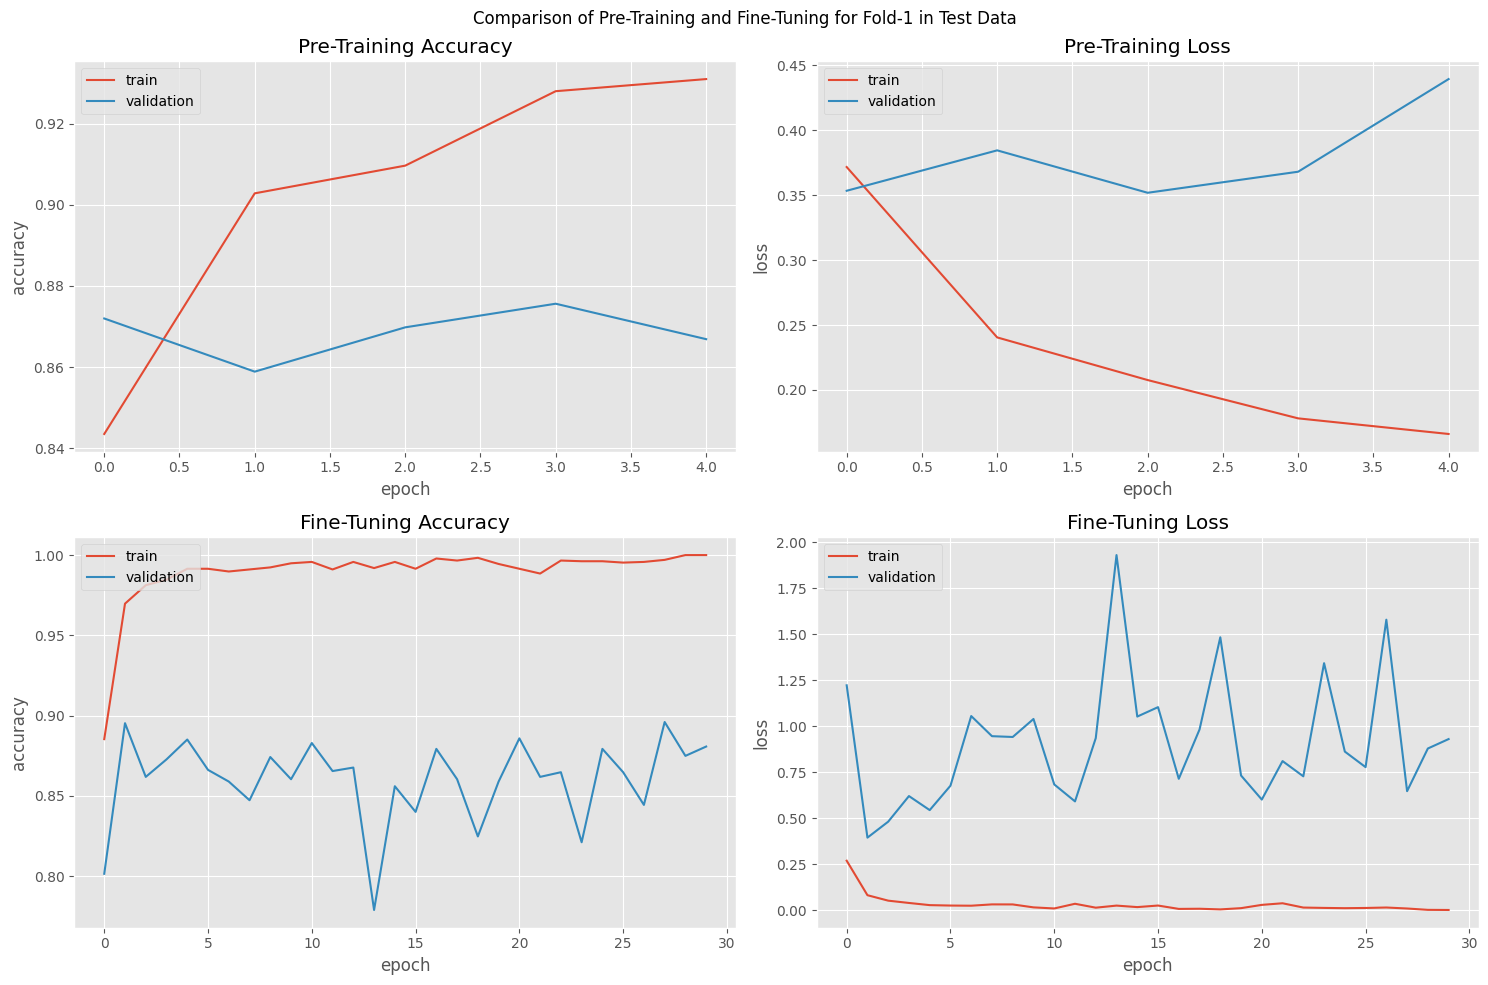

History plot saved!
Confusion Matrix:
 [[122  45]
 [ 17 324]]


 33%|███▎      | 1/3 [00:01<00:02,  1.41s/it]

Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.88      0.73      0.80       167
        osmf       0.88      0.95      0.91       341

    accuracy                           0.88       508
   macro avg       0.88      0.84      0.86       508
weighted avg       0.88      0.88      0.87       508

Classification Report saved!
Done!
Saving results for fold 1...Done!

Saving results for fold 2...


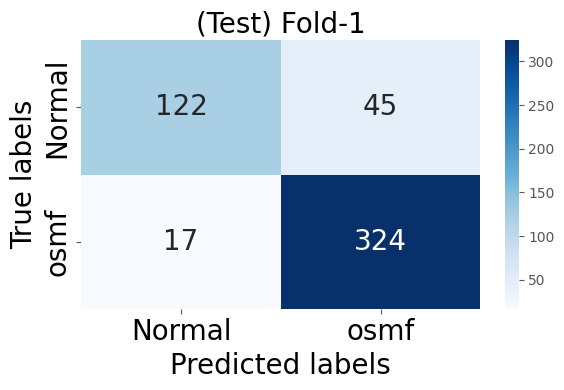

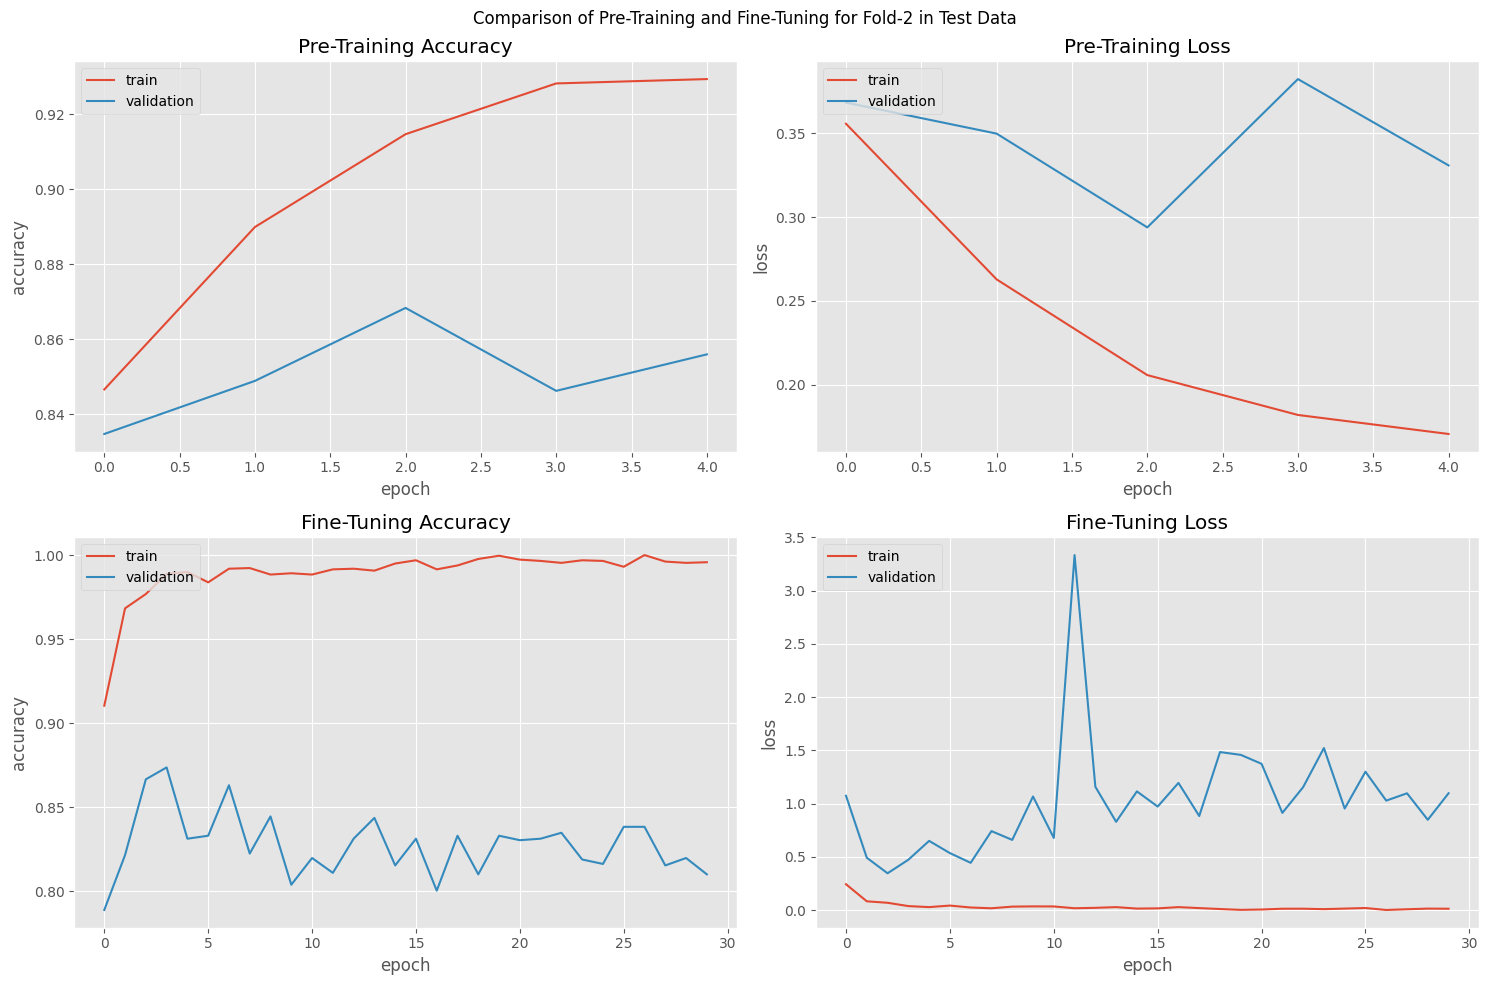

 67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

History plot saved!
Confusion Matrix:
 [[123  44]
 [ 28 313]]
Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.81      0.74      0.77       167
        osmf       0.88      0.92      0.90       341

    accuracy                           0.86       508
   macro avg       0.85      0.83      0.84       508
weighted avg       0.86      0.86      0.86       508

Classification Report saved!
Done!
Saving results for fold 2...Done!

Saving results for fold 3...


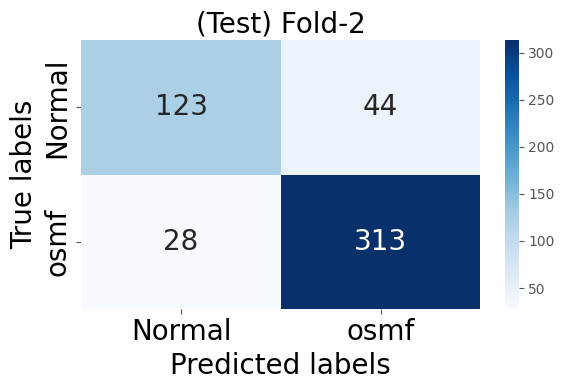

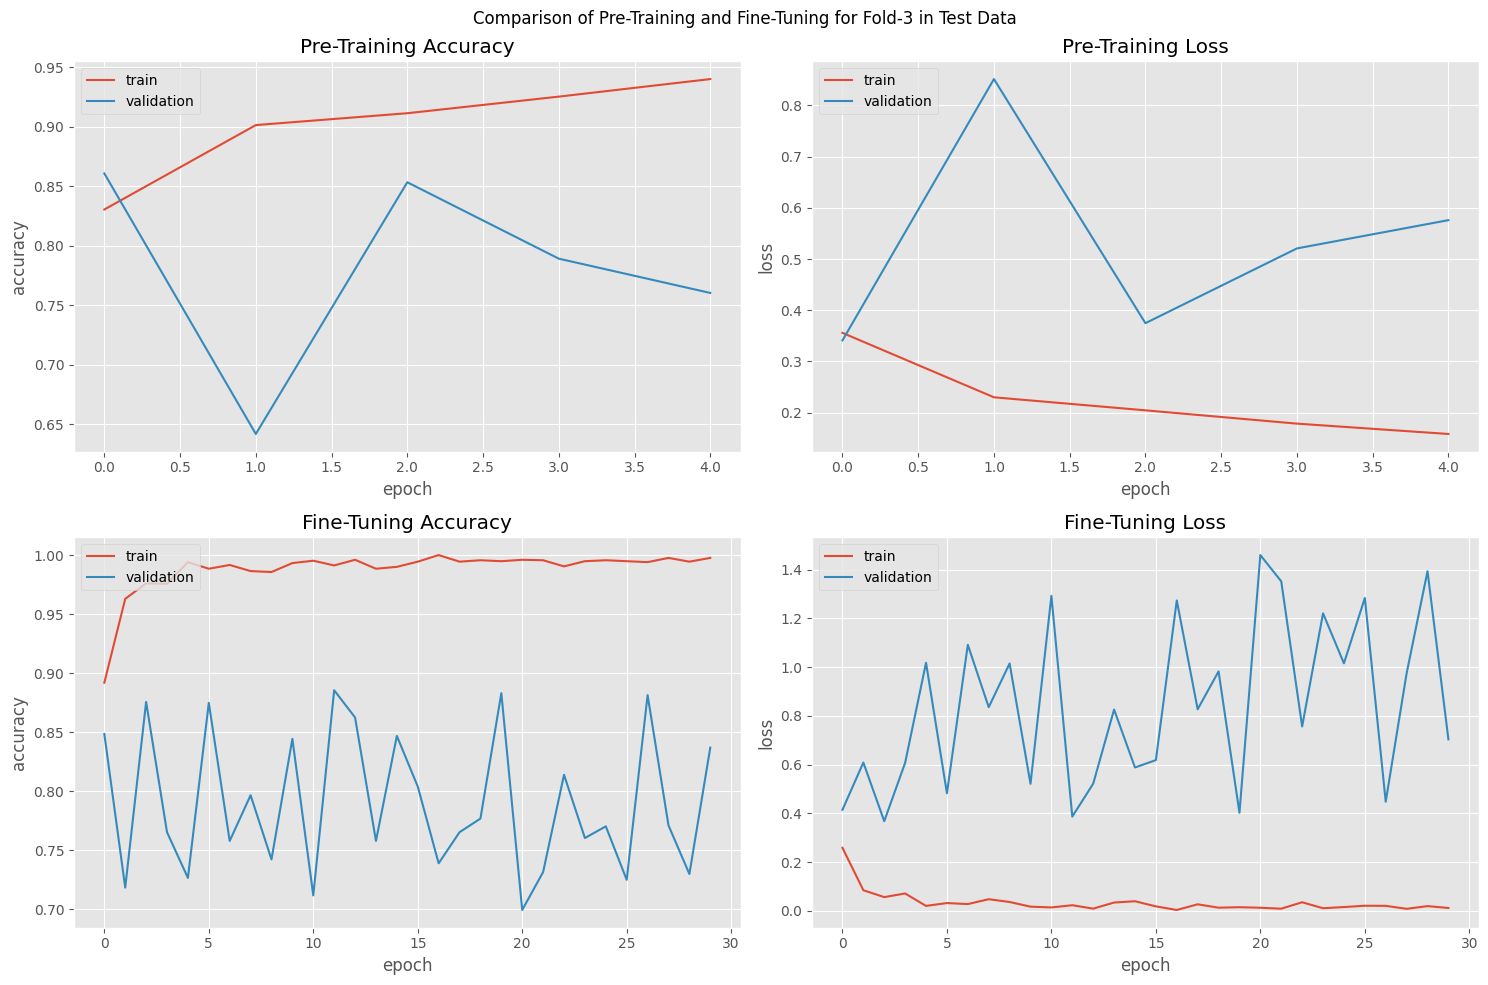

100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

History plot saved!
Confusion Matrix:
 [[127  40]
 [ 22 319]]
Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.85      0.76      0.80       167
        osmf       0.89      0.94      0.91       341

    accuracy                           0.88       508
   macro avg       0.87      0.85      0.86       508
weighted avg       0.88      0.88      0.88       508

Classification Report saved!
Done!
Saving results for fold 3...Done!



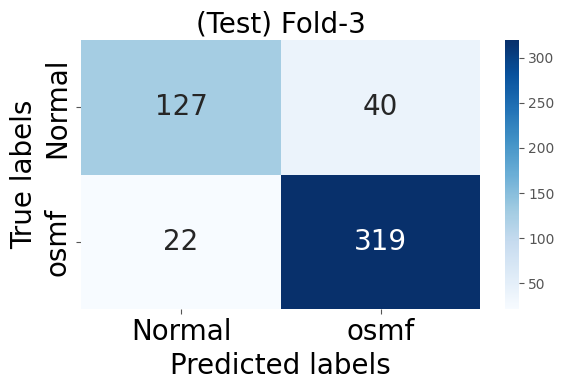

In [18]:
folds = [1,2,3]
target_names = ['Normal', 'osmf']
for fold in tqdm(folds):
    print(f'Saving results for fold {fold}...')
    history_pre_path = f'./results/fold-{fold}/hist_pre.pkl'
    history_fine_path = f'./results/fold-{fold}/hist_fine.pkl'
    results_path = f'./results/fold-{fold}/results_test.csv'
    save_results(history_pre_path, history_fine_path, results_path, target_names, fold)
    print(f'Saving results for fold {fold}...Done!', end='\n\n')

  0%|          | 0/3 [00:00<?, ?it/s]

Saving results for fold 1...


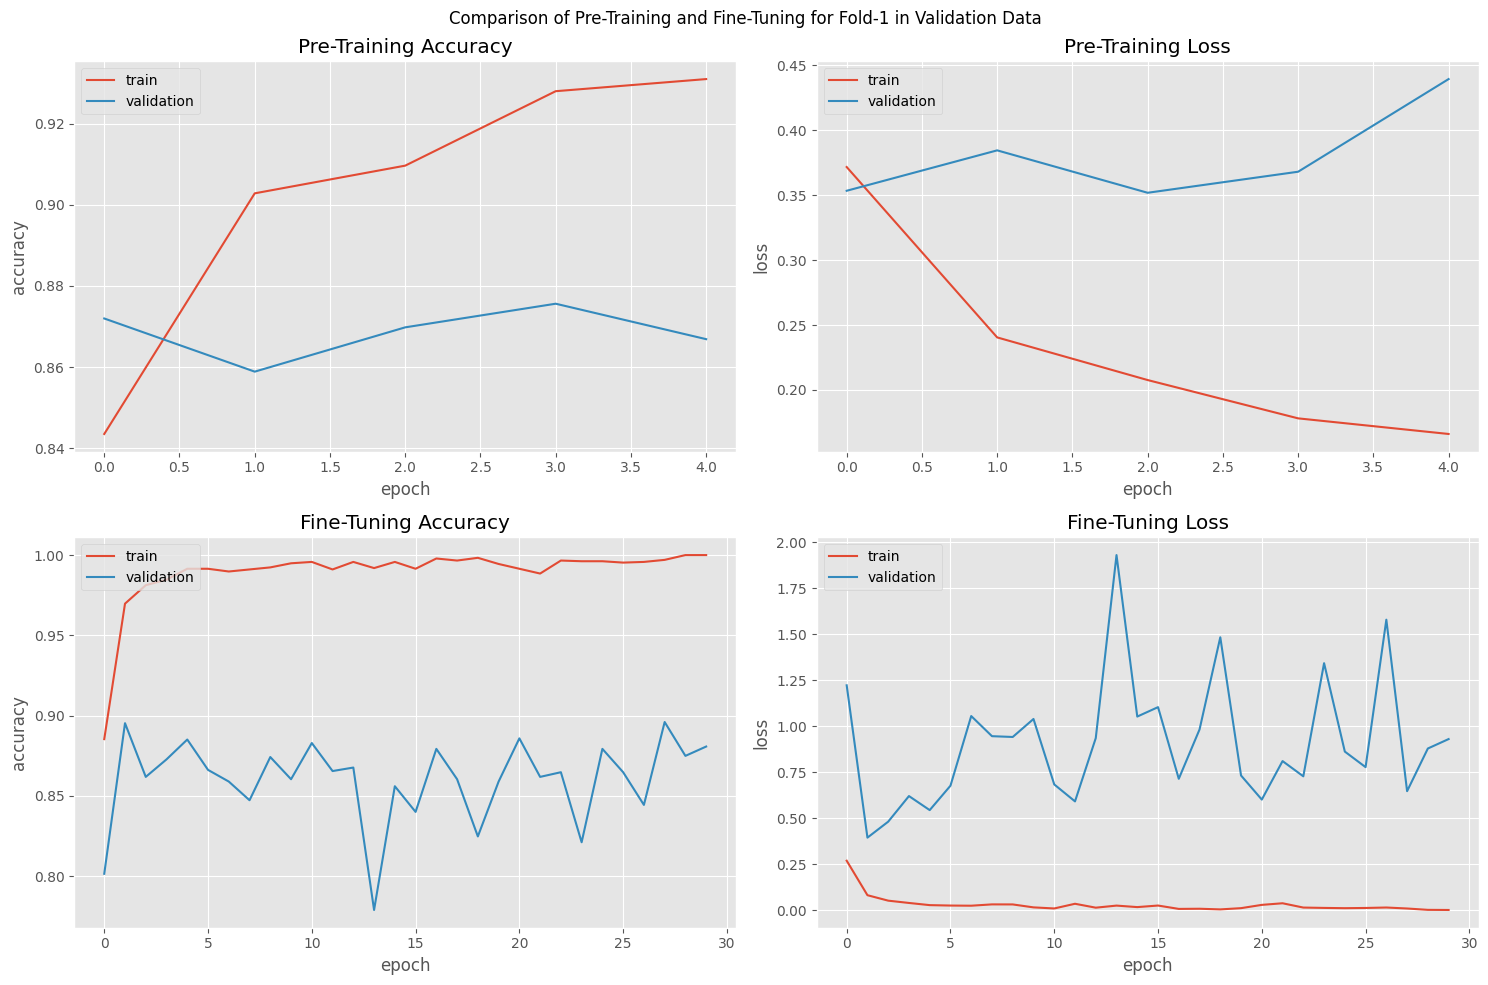

 33%|███▎      | 1/3 [00:01<00:02,  1.14s/it]

History plot saved!
Confusion Matrix:
 [[15 49]
 [44 89]]
Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.25      0.23      0.24        64
        osmf       0.64      0.67      0.66       133

    accuracy                           0.53       197
   macro avg       0.45      0.45      0.45       197
weighted avg       0.52      0.53      0.52       197

Classification Report saved!
Done!
Saving results for fold 1...Done!

Saving results for fold 2...


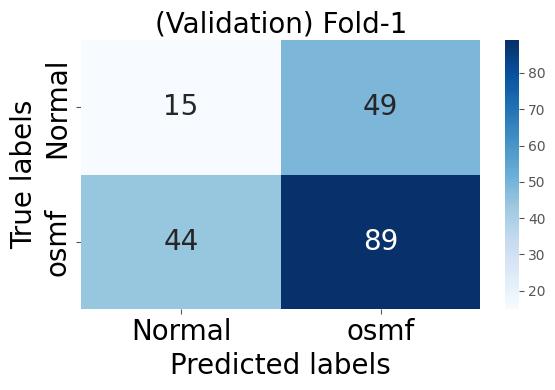

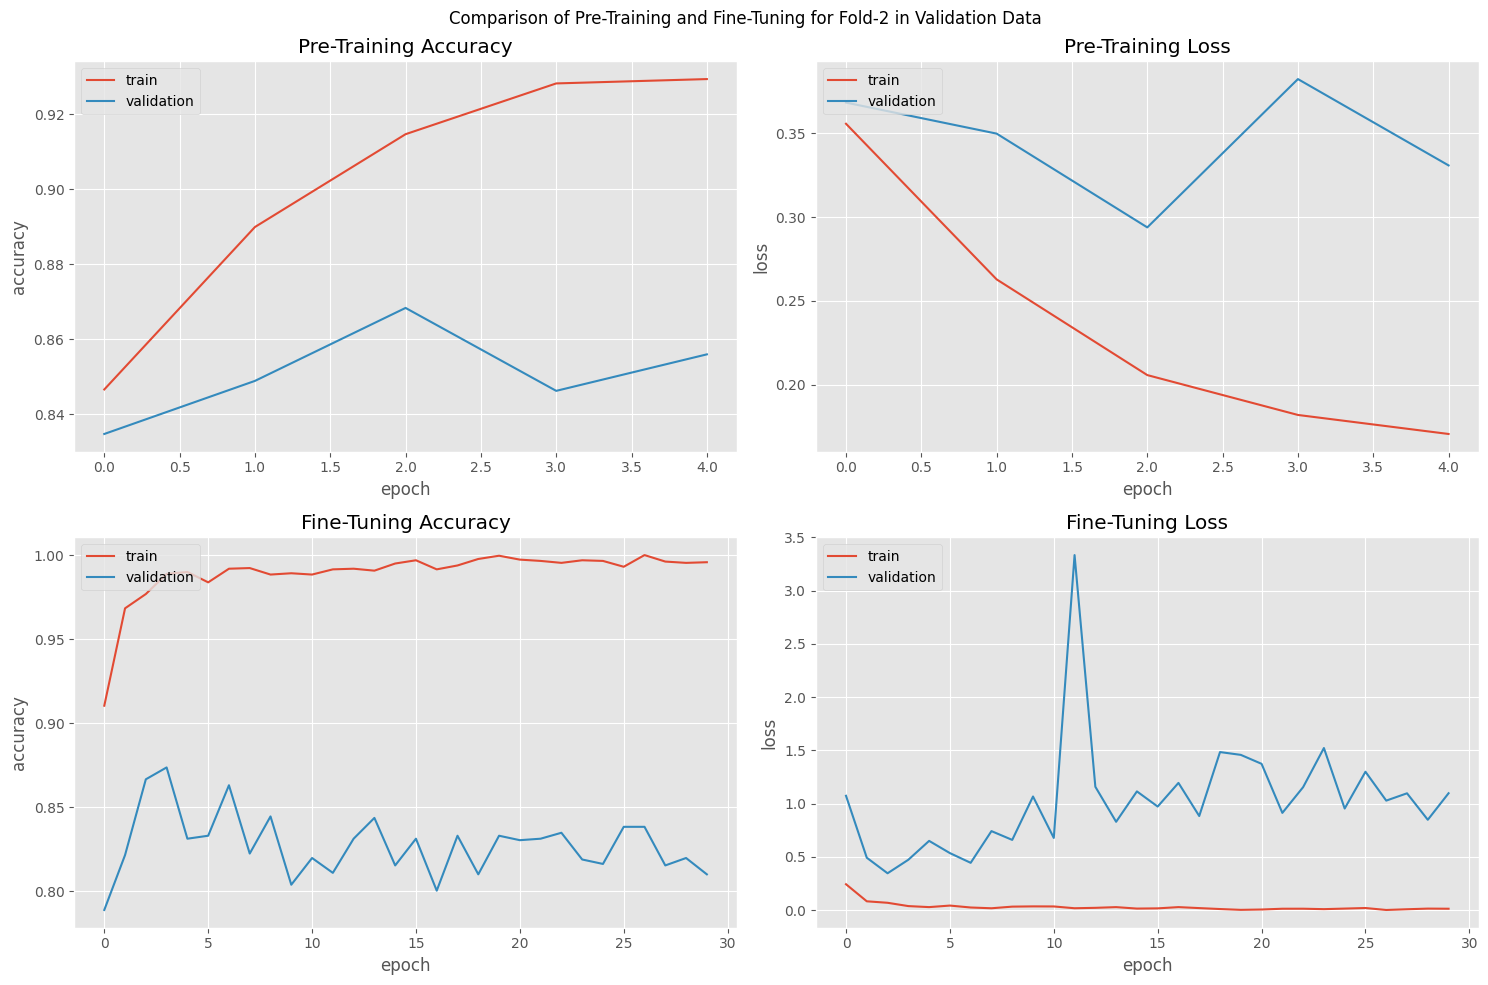

 67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]

History plot saved!
Confusion Matrix:
 [[17 47]
 [42 91]]
Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.29      0.27      0.28        64
        osmf       0.66      0.68      0.67       133

    accuracy                           0.55       197
   macro avg       0.47      0.47      0.47       197
weighted avg       0.54      0.55      0.54       197

Classification Report saved!
Done!
Saving results for fold 2...Done!

Saving results for fold 3...


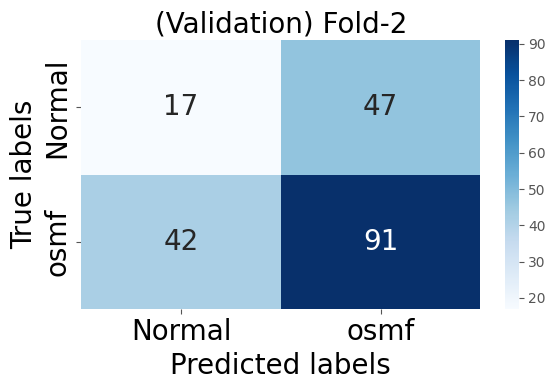

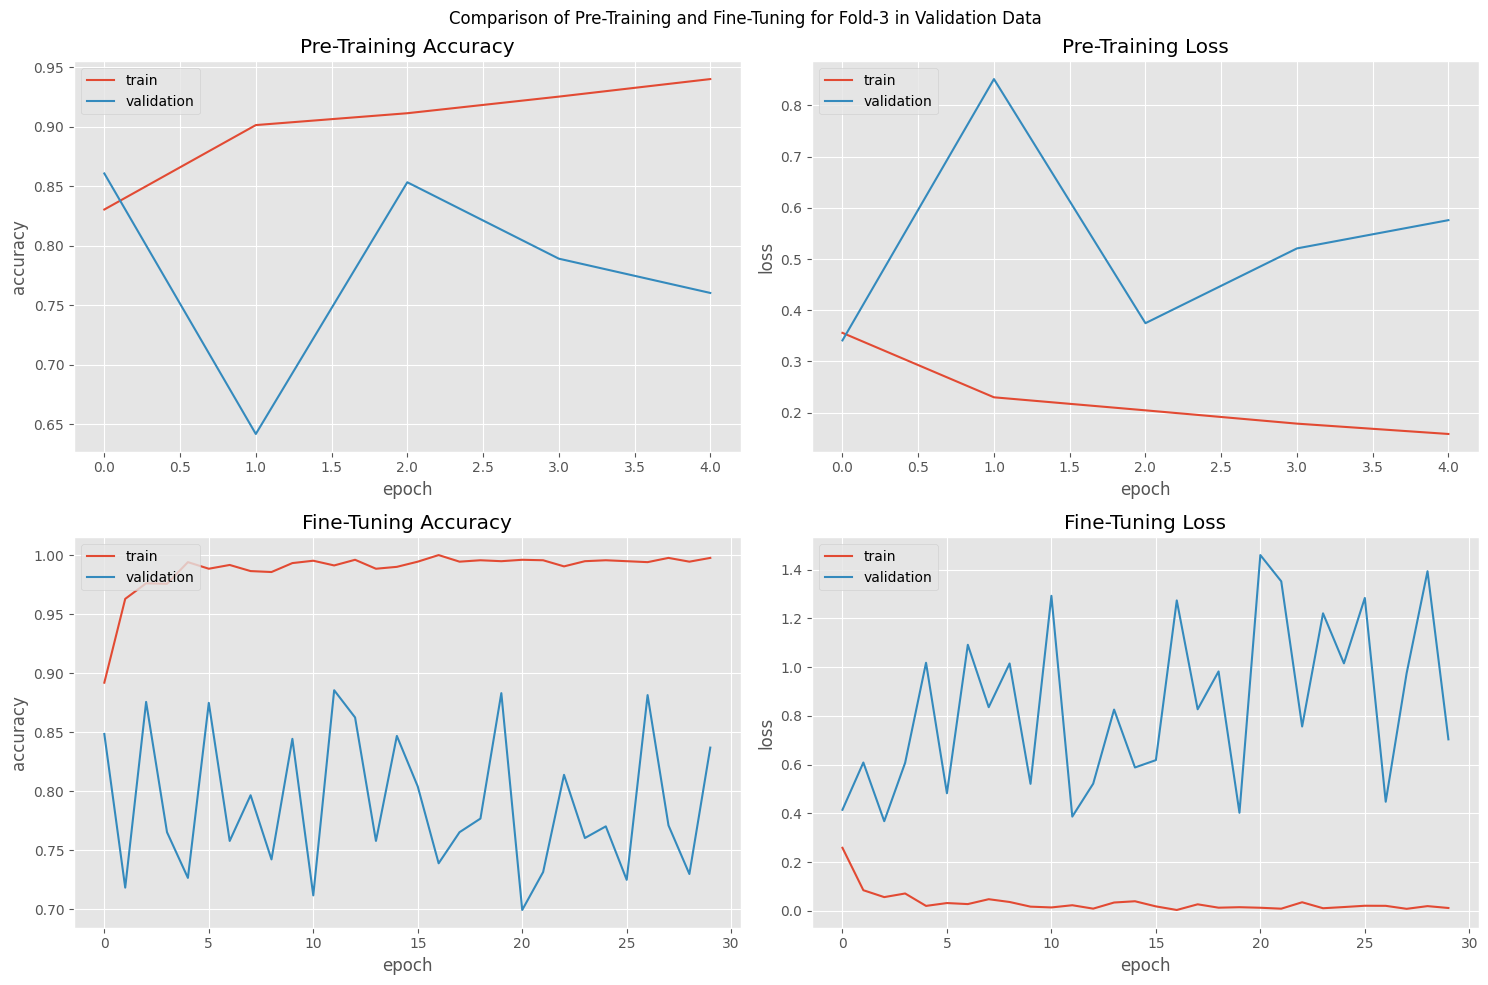

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

History plot saved!
Confusion Matrix:
 [[19 45]
 [46 87]]
Confusion Matrix plot saved!
Classification Report:
               precision    recall  f1-score   support

      Normal       0.29      0.30      0.29        64
        osmf       0.66      0.65      0.66       133

    accuracy                           0.54       197
   macro avg       0.48      0.48      0.48       197
weighted avg       0.54      0.54      0.54       197

Classification Report saved!
Done!
Saving results for fold 3...Done!



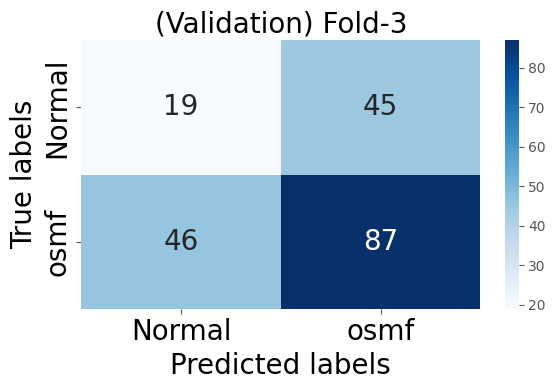

In [19]:
folds = [1,2,3]
target_names = ['Normal', 'osmf']
for fold in tqdm(folds):
    print(f'Saving results for fold {fold}...')
    history_pre_path = f'./results/fold-{fold}/hist_pre.pkl'
    history_fine_path = f'./results/fold-{fold}/hist_fine.pkl'
    results_path = f'./results/fold-{fold}/results_val.csv'
    save_results(history_pre_path, history_fine_path, results_path, target_names, fold, isVal=True)
    print(f'Saving results for fold {fold}...Done!', end='\n\n')